In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
import scipy.ndimage 
import os
import spectral
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid
import plotly.graph_objects as go


/var/folders/v4/x79lpxvj6vn2jfzsmhbhd3yw0000gn/T/ipykernel_14882/2631301171.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def loadData(name, datasetFolderPath):
    if name == "Indian_Pines":
        data_path = os.path.join(datasetFolderPath, name, "Indian_pines_corrected.mat")
        labels_path = os.path.join(datasetFolderPath, name, "Indian_pines_gt.mat")
        
        
        if os.path.exists(data_path) and os.path.exists(labels_path):
            data = scio.loadmat(data_path)["indian_pines_corrected"]
            labels = scio.loadmat(labels_path)["indian_pines_gt"]
            return data, labels
        else:
            raise FileNotFoundError("Data files not found for Indian_Pines dataset.")
    else:
        raise ValueError("Unsupported dataset name. Only Indian_Pines is supported.")


### 1. Load the Data

In [3]:
datasetFolderPath = "Data"
name = "Indian_Pines"
X,y = loadData(name, datasetFolderPath)

### 2. Understand the Data

In [4]:
print("Dimensions of data:", X.shape)
print("Dimensions of labels:", y.shape)
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

Dimensions of data: (145, 145, 200)
Dimensions of labels: (145, 145)
Number of classes: 17


### 3. Visualize the Data

/Users/ashutoshbaruah/Documents/development_project/Mtech_Thesis/venv/lib/python3.11/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


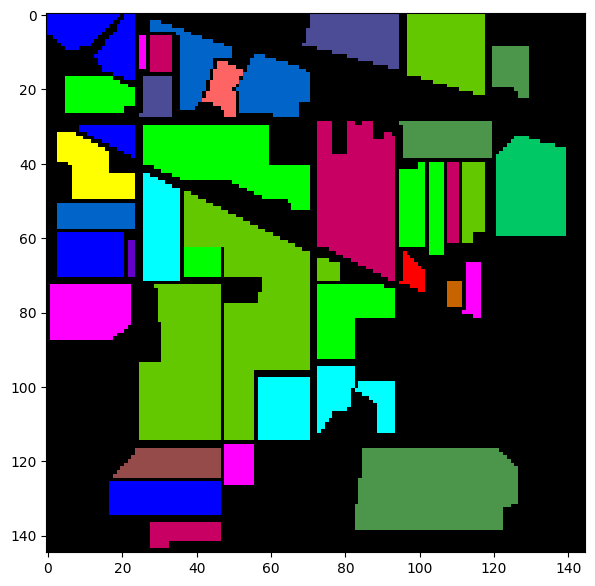

In [5]:
# Ground Truth

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

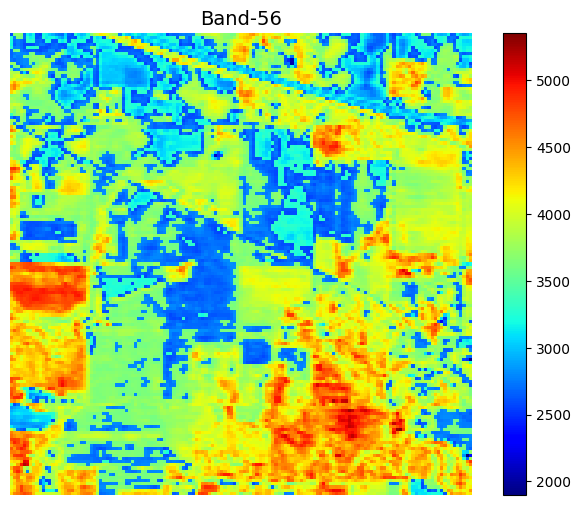

In [6]:
def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    band_no = np.random.randint(dataset.shape[2])
    plt.imshow(dataset[:,:, band_no], cmap='jet')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
plot_band(X)

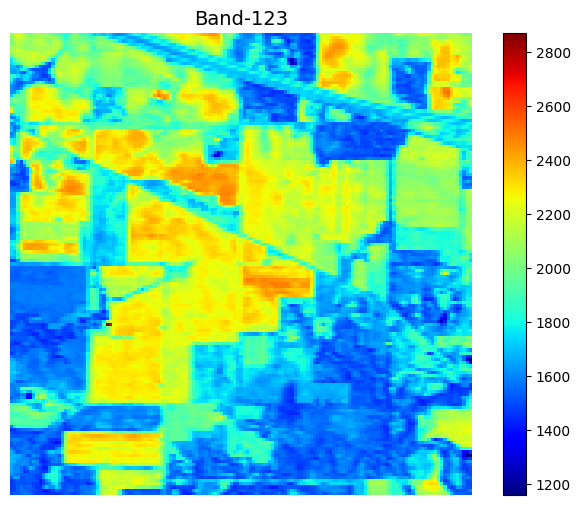

In [11]:
def plot_band(data, band_number):
    """
    Visualize a specific band of hyperspectral data using Plotly.
    
    Parameters:
    - data: Hyperspectral data array of shape [bands, height, width].
    - band_number: The band number to visualize.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(data[:,:, band_number], cmap='jet')
    plt.title(f'Band-{band_number}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
# Example usage
band_number = 123  

plot_band(X, band_number)



In [13]:
def plot_spectral_signature(data, pixel_row, pixel_col):
    """
    Plot the spectral signature of a specific pixel across all bands using Plotly.
    
    Parameters:
    - data: Hyperspectral data array of shape [bands, height, width].
    - pixel_row: Row number of the pixel.
    - pixel_col: Column number of the pixel.
    """
    spectral_signature = data[:, pixel_row, pixel_col]
    bands = list(range(data.shape[0]))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=bands, y=spectral_signature,
                             mode='lines+markers',
                             name='Spectral Signature'))
    fig.update_layout(title=f'Spectral Signature of Pixel ({pixel_row}, {pixel_col})',
                      xaxis_title='Band',
                      yaxis_title='Reflectance')
    fig.show()
    

#Example Usage

pixel_row, pixel_col = 120, 50  # Change these to inspect a different pixel

plot_spectral_signature(X, pixel_row, pixel_col)

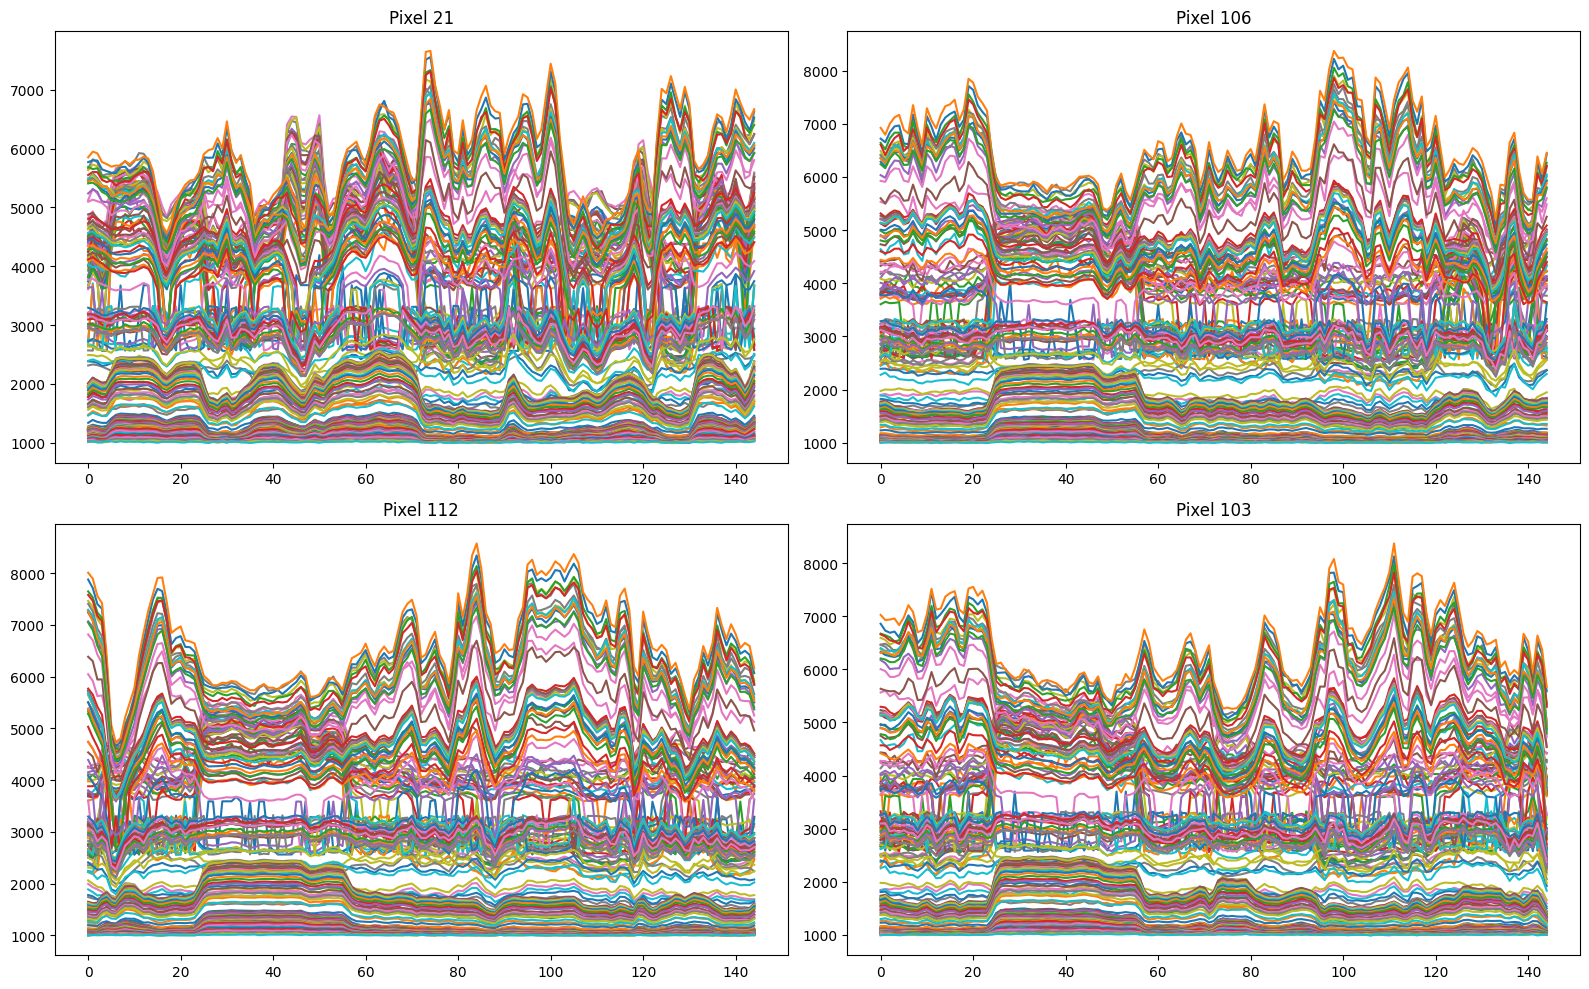

In [14]:
def plot_spectrum_random_pixels(data):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    for i, ax in enumerate(axes.flat):
        sample_idx = np.random.randint(0, X.shape[0])
        ax.plot(data[sample_idx])
        ax.set_title(f"Pixel {sample_idx}") #Class {y[sample_idx]}
    plt.tight_layout()
    plt.show()
    
plot_spectrum_random_pixels(X)

### Visualize Data

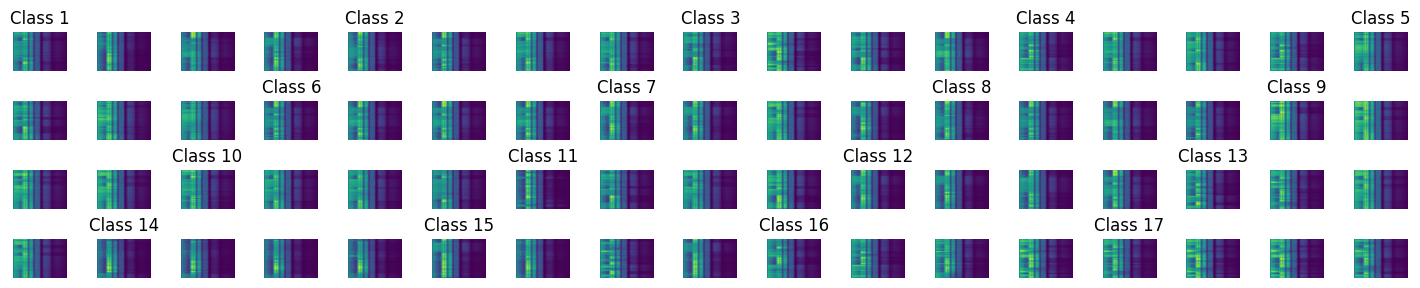

In [15]:
def visualize_samples(X, y, num_samples=4):
    fig = plt.figure(figsize=(18, 56))
    grid = ImageGrid(fig,111, nrows_ncols=(num_samples, num_classes), axes_pad=0.3)

    for class_label in range(num_classes):
        class_indices = np.where(y == class_label)[0]
        if len(class_indices) < num_samples:
            print(f"Warning: Class {class_label + 1} has fewer than {num_samples} samples.")
            selected_indices = class_indices
        else:
            selected_indices = np.random.choice(class_indices, num_samples, replace=False)

        for i, idx in enumerate(selected_indices):
            ax = grid[num_samples * class_label + i]
            ax.imshow(X[idx])
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Class {class_label + 1}")

visualize_samples(X, y)

### 4. Class Distribution

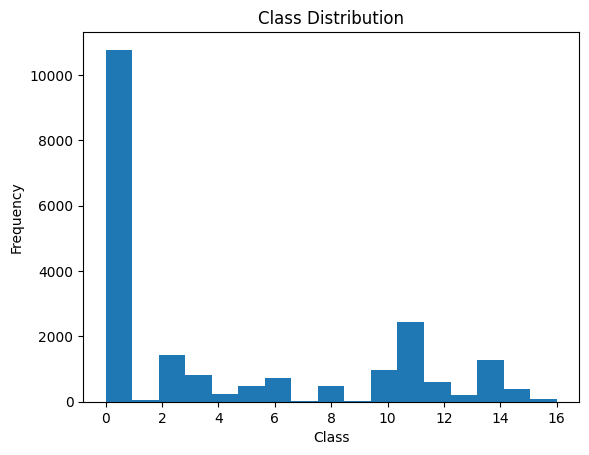

In [21]:
plt.hist(y.flatten(), bins=num_classes)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

### 5. Feature Analysis

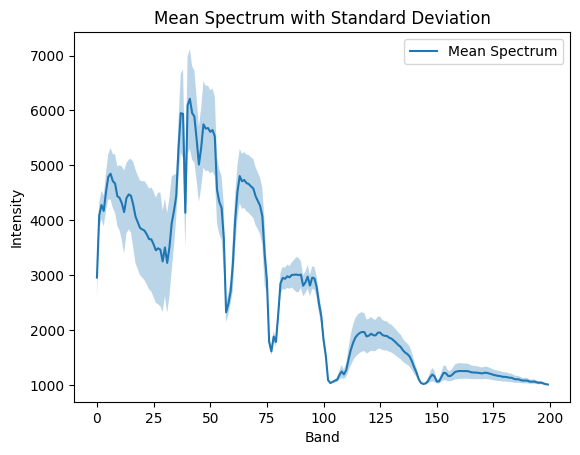

In [22]:
mean_spectrum = np.mean(X, axis=(0, 1))
std_spectrum = np.std(X, axis=(0, 1))
plt.plot(mean_spectrum, label='Mean Spectrum')
plt.fill_between(range(len(mean_spectrum)), mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.3)
plt.title("Mean Spectrum with Standard Deviation")
plt.xlabel("Band")
plt.ylabel("Intensity")
plt.legend()
plt.show()

### 6. Dimensionality Reduction (PCA)

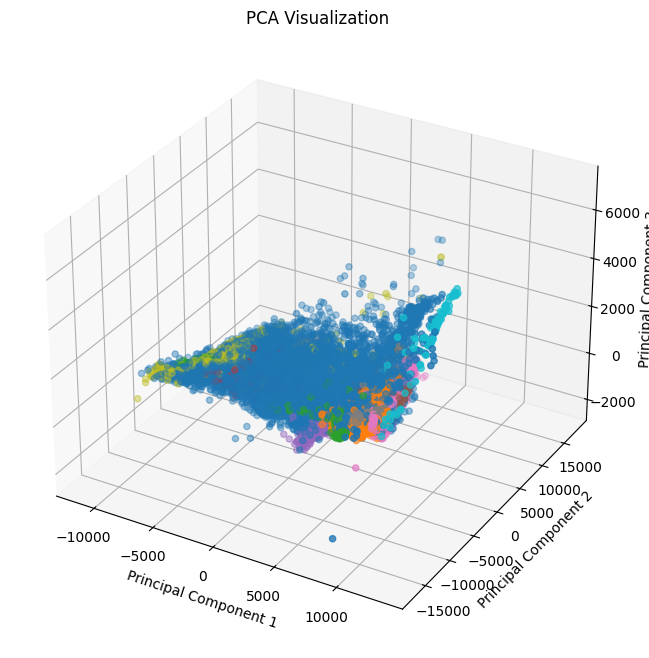

In [25]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.reshape(-1, X.shape[2]))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.tab10(y.flatten() / num_classes)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors)
ax.set_title("PCA Visualization")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()